In [1]:
import tensorflow as tf
import numpy as np
import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
Tokenizer = tf.keras.preprocessing.text.Tokenizer

In [5]:
# initialise sentences 
sentences = ["I love my dog", "I LOVE MY CAT!", "You love my dog", "Do you think my dog is amazing?"]

you define the number of relevant words in the string sequence that are relevant. Then you pass the train data into your tokenizer and you can check what tokens are given to your data by using the `word_index` method. The module is designed to lemmatise the words and ignores punctuation and capitalisation. 

`num_words` takes the top n words and creates a vocab out of those. the rest would be out of vocab words. 

In [6]:
tokenizer = Tokenizer(num_words = 100)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_index

{'my': 1,
 'love': 2,
 'dog': 3,
 'i': 4,
 'you': 5,
 'cat': 6,
 'do': 7,
 'think': 8,
 'is': 9,
 'amazing': 10}

You can also see that applying these tokens to your sentences converts them into an array of integers ready to be processed. You can see that each sequence has different number of words in them and so different length arrays. 

In [7]:
sequences = tokenizer.texts_to_sequences(sentences)
sequences

[[4, 2, 1, 3], [4, 2, 1, 6], [5, 2, 1, 3], [7, 5, 8, 1, 3, 9, 10]]

Now what if your tokeniser has not assigned a value to new words that it sees in its test data?

In [8]:
test_data = ["i really love my dog", "my dog loves my shoes"]
test_seq = tokenizer.texts_to_sequences(test_data)
test_seq

[[4, 2, 1, 3], [1, 3, 1]]

One way to tackle this is by creating a token for Out Of Vocabulary words and assigning that to any new word that you see. Now our sequences are the same length as the actual sentences even though we have still lost some meaning.

In [9]:
tokenizer_oov = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer_oov.fit_on_texts(sentences)
word_index = tokenizer_oov.word_index
word_index

{'<OOV>': 1,
 'my': 2,
 'love': 3,
 'dog': 4,
 'i': 5,
 'you': 6,
 'cat': 7,
 'do': 8,
 'think': 9,
 'is': 10,
 'amazing': 11}

In [10]:
test_seq = tokenizer_oov.texts_to_sequences(test_data)
test_seq

[[5, 1, 3, 2, 4], [2, 4, 1, 2, 1]]

Now that we are getting close to building the neural network and processing matrices that we have created we need to think about what if your sentences are not the same length? One method is using a *"ragged tensor"* which we will not look at. Another method is padding.

In [12]:
# use kwarg 
#   padding="post" to pad on the left
#   maxlen=# to pad to a specific length
# if maxlen is smaller than longest sentences use truncating="post"/"pre" to define cutoffs
padded_sequences = pad_sequences(sequences) 
padded_sequences

array([[ 0,  0,  0,  4,  2,  1,  3],
       [ 0,  0,  0,  4,  2,  1,  6],
       [ 0,  0,  0,  5,  2,  1,  3],
       [ 7,  5,  8,  1,  3,  9, 10]])

# Sarcastic news titles

Im gonna use the kaggle API to download the dataset as JSON. Train our data and test... the usual

In [2]:
import json
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [15]:
# copied from kaggle the API command to download the dataset
# kaggle datasets download -d rmisra/news-headlines-dataset-for-sarcasm-detection

# Download all files of a dataset
# Signature: dataset_download_files(dataset, path=None, force=False, quiet=True, unzip=False)

#api.dataset_download_files("rmisra/news-headlines-dataset-for-sarcasm-detection")

In [13]:
with open("data/Sarcasm_Headlines_Dataset.json","r") as file:
    raw = file.readlines()
    data = {"root":[]}
    for line in raw:
        data["root"].append(json.loads(line))

sentences = [data["root"][i]["headline"] for i in range(len(data["root"]))]
labels = [data["root"][i]["is_sarcastic"] for i in range(len(data["root"]))]

In [16]:
training_size = 20000

train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

In [17]:
vocab_size = 10000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

train_word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding="post")

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding="post")

In [19]:
# Need this block to get it to work with TensorFlow 2.x
train_padded = np.array(train_padded).astype("int")
train_labels = np.array(train_labels).astype("int")
test_padded = np.array(test_padded).astype("int")
test_labels = np.array(test_labels).astype("int")

In [20]:
train_padded.shape
# we have 20000 sentences, longest of which must have been 40 words long

(20000, 40)

Now it comes to building the neural network. Sequential is a model class which carries out the model in a sequence. 
- The first item is embedding. The direction/vector representation/tone of each word will be learned epoch by epoch
- Next you calculate the global average of these directions given their context
- Dense is a layer of interconnected neurons and here we have used 2 layers, the first having 24 and the latter having 1 nodes. this makes the decision on what the sentiment is

**Embedding** 
1. you choose a number of dimensions and assign a vector to each word. The dimensions define the sentiment that each word can have. Words are not just one dimensional that go in either a good or bad direction that's why we give it 16 dimensions. 
2. over time the training clusters similar words together according to the labels and creates the embedding.  
3. The result of the embedding is a 2d Array of length of the sentences and a dimension. You can either flatten this or use a global average of the vectors to then feed it into the dense layers for the decision making.

In [20]:
embedding_dim = 16
max_length = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1 ,activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
history = model.fit(train_padded, train_labels, epochs=30, validation_data=(test_padded, test_labels), verbose=2)

Epoch 1/30


625/625 - 2s - loss: 0.6061 - accuracy: 0.6630 - val_loss: 0.4306 - val_accuracy: 0.8180
Epoch 2/30
625/625 - 1s - loss: 0.3393 - accuracy: 0.8641 - val_loss: 0.3480 - val_accuracy: 0.8536
Epoch 3/30
625/625 - 1s - loss: 0.2545 - accuracy: 0.8996 - val_loss: 0.3406 - val_accuracy: 0.8593
Epoch 4/30
625/625 - 1s - loss: 0.2075 - accuracy: 0.9201 - val_loss: 0.3501 - val_accuracy: 0.8542
Epoch 5/30
625/625 - 1s - loss: 0.1754 - accuracy: 0.9344 - val_loss: 0.3674 - val_accuracy: 0.8559
Epoch 6/30
625/625 - 1s - loss: 0.1497 - accuracy: 0.9448 - val_loss: 0.3949 - val_accuracy: 0.8532
Epoch 7/30
625/625 - 1s - loss: 0.1293 - accuracy: 0.9546 - val_loss: 0.4271 - val_accuracy: 0.8448
Epoch 8/30
625/625 - 1s - loss: 0.1132 - accuracy: 0.9603 - val_loss: 0.4566 - val_accuracy: 0.8463
Epoch 9/30
625/625 - 1s - loss: 0.0989 - accuracy: 0.9671 - val_loss: 0.4960 - val_accuracy: 0.8416
Epoch 10/30
625/625 - 1s - loss: 0.0870 - accuracy: 0.9718 - val_loss: 0.5422 - val_accuracy: 0.8372
Epoch 11/3

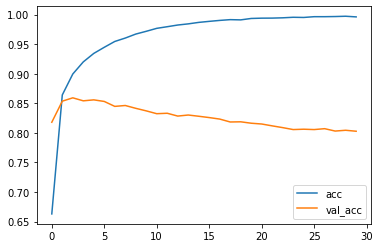

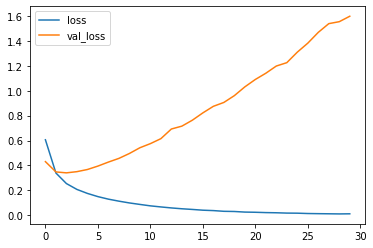

In [28]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["acc", "val_acc"])
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])


In [23]:
new_sentences = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]

new_sequences = tokenizer.texts_to_sequences(new_sentences)
new_pads = pad_sequences(new_sequences, maxlen=max_length, padding="post", truncating="post")

model.predict(new_pads)

array([[7.6833975e-01],
       [1.0817187e-04]], dtype=float32)

what we see is that the model predicts the first sentence to be 80% probable to be sarcastic whereas the second sentence is very unlikely to be sarcastic. 

In the above you can see that as the training lines plateau, the validation lines begin to trend. The loss for example on the trianing set started to plateau after epoch 3 (the elbow) and the val_loss began on a linear upward trend. This means that the confidence per prediction decreased so we shall tweak the hyper_params and re-run the model. 

In [29]:
vocab_size = 1000 # was 10,000
embedding_dim = 16 # increasing the num_dims have proven to have little difference
max_length = 16 # was 32
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
training_size = 20000

In [31]:
train_sentences = sentences[:training_size]
train_labels = labels[:training_size]

test_sentences = sentences[training_size:]
test_labels = labels[training_size:]
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

train_word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding=padding_type)

train_padded = np.array(train_padded).astype("int")
train_labels = np.array(train_labels).astype("int")
test_padded = np.array(test_padded).astype("int")
test_labels = np.array(test_labels).astype("int")

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation="relu"),
    tf.keras.layers.Dense(1 ,activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_padded, train_labels, epochs=30, validation_data=(test_padded, test_labels), verbose=2)

Epoch 1/30


625/625 - 1s - loss: 0.5972 - accuracy: 0.6673 - val_loss: 0.4502 - val_accuracy: 0.7980
Epoch 2/30
625/625 - 1s - loss: 0.4060 - accuracy: 0.8124 - val_loss: 0.4063 - val_accuracy: 0.8120
Epoch 3/30
625/625 - 1s - loss: 0.3742 - accuracy: 0.8310 - val_loss: 0.4023 - val_accuracy: 0.8109
Epoch 4/30
625/625 - 1s - loss: 0.3629 - accuracy: 0.8356 - val_loss: 0.4042 - val_accuracy: 0.8155
Epoch 5/30
625/625 - 1s - loss: 0.3572 - accuracy: 0.8378 - val_loss: 0.4020 - val_accuracy: 0.8156
Epoch 6/30
625/625 - 1s - loss: 0.3541 - accuracy: 0.8405 - val_loss: 0.4026 - val_accuracy: 0.8128
Epoch 7/30
625/625 - 1s - loss: 0.3517 - accuracy: 0.8392 - val_loss: 0.4143 - val_accuracy: 0.8132
Epoch 8/30
625/625 - 1s - loss: 0.3502 - accuracy: 0.8396 - val_loss: 0.4061 - val_accuracy: 0.8143
Epoch 9/30
625/625 - 1s - loss: 0.3501 - accuracy: 0.8399 - val_loss: 0.4094 - val_accuracy: 0.8109
Epoch 10/30
625/625 - 1s - loss: 0.3486 - accuracy: 0.8414 - val_loss: 0.4092 - val_accuracy: 0.8126
Epoch 11/3

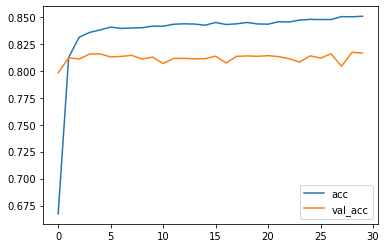

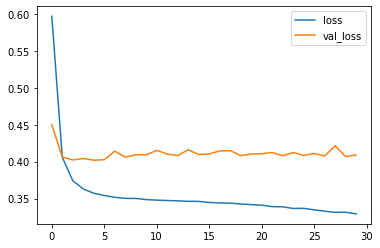

In [32]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["acc", "val_acc"])
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])


# IMDB reviews


In [3]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True, shuffle_files=True)

In [44]:
train_data, test_data = imdb["train"], imdb["test"]
# each are stored as tf.Tensor objects and the labels as 1 for a positive and 0 for a negative review

In [45]:
training_sentences, training_labels = [], []
testing_sentences, testing_labels = [], []

for string, label in train_data:
    training_sentences.append(str(string.numpy()))
    training_labels.append(str(label.numpy()))

for string, label in test_data:
    testing_sentences.append(str(string.numpy()))
    testing_labels.append(str(label.numpy()))

training_labels = np.array(training_labels).astype("int")
testing_labels = np.array(testing_labels).astype("int")

In [6]:
vocab_size = 10000
embedding_dim = 16 
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(), # slower than global averaging but more accurate
    tf.keras.layers.Dense(6,activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 10
model.fit(padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))
# the results should be slightly overfit because the accuracy is 1 but validation loss goes up

Epoch 1/10
782/782 [==============================] - 3s 3ms/step - loss: 0.4888 - accuracy: 0.7479 - val_loss: 0.3443 - val_accuracy: 0.8509
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.2376 - accuracy: 0.9095 - val_loss: 0.3701 - val_accuracy: 0.8389
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0896 - accuracy: 0.9769 - val_loss: 0.4514 - val_accuracy: 0.8266
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0224 - accuracy: 0.9975 - val_loss: 0.5422 - val_accuracy: 0.8244
Epoch 5/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0065 - accuracy: 0.9994 - val_loss: 0.5953 - val_accuracy: 0.8265
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.6509 - val_accuracy: 0.8240
Epoch 7/10
782/782 [==============================] - 3s 3ms/step - loss: 9.3938e-04 - accuracy: 1.0000 - val_loss: 0.6942 - val_accuracy: 0.8263
Ep

In [10]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # (vocab_size, embedding_dim)

(10000, 16)


In [11]:
reverse_word_index = {value:key for key,value in word_index.items()}

In [12]:
# write vectors to a metadata outfile
out_vector = io.open("data/sentiment_analysis/vecs.tsv", "w", encoding="utf-8")
out_metadata = io.open("data/sentiment_analysis/meta.tsv", "w", encoding="utf-8")

for word_num in range(1,vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_metadata.write(word+"\n")
    out_vector.write("\t".join([str(x) for x in embeddings])+"\n")

out_vector.close()
out_metadata.close()

In [ ]:
# https://projector.tesorflow.org to visualise the vectors

# Pre-tokenized dataset

In [50]:
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True, shuffle_files=True)

In [51]:
train_data, test_data = imdb["train"], imdb["test"]

tokenizer = info.features["text"].encoder

In [52]:
# inspect vocab
print(tokenizer.subwords[:10])

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br']


you can see that the encoder has punctuation in its vocab. This encoder is case sensitive and stores more properties of the order of the letters, words and sentences. 

In [53]:
sample_string = "TensorFlow, from basics to mastery"

tokenized_string = tokenizer.encode(sample_string)
print(tokenized_string)

original_string = tokenizer.decode(tokenized_string)
print(original_string)

[6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
TensorFlow, from basics to mastery


In [40]:
for tokenised_str in tokenized_string:
    print(f"{tokenised_str} --> {tokenizer.decode([tokenised_str])}")

6307 --> Ten
2327 --> sor
4043 --> Fl
2120 --> ow
2 --> , 
48 --> from 
4249 --> basi
4429 --> cs 
7 --> to 
2652 --> master
8050 --> y


# reclassify the IMDB dataset with preloaded tokenizer

In [54]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [56]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [58]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 11s 26ms/step - loss: 0.6738 - accuracy: 0.6184 - val_loss: 0.6274 - val_accuracy: 0.7500
Epoch 2/10
391/391 [==============================] - 11s 27ms/step - loss: 0.5218 - accuracy: 0.8146 - val_loss: 0.4460 - val_accuracy: 0.8353
Epoch 3/10
391/391 [==============================] - 11s 27ms/step - loss: 0.3665 - accuracy: 0.8767 - val_loss: 0.3683 - val_accuracy: 0.8561
Epoch 4/10
391/391 [==============================] - 10s 26ms/step - loss: 0.2971 - accuracy: 0.8968 - val_loss: 0.3268 - val_accuracy: 0.8751
Epoch 5/10
391/391 [==============================] - 11s 27ms/step - loss: 0.2595 - accuracy: 0.9078 - val_loss: 0.3119 - val_accuracy: 0.8789
Epoch 6/10
391/391 [==============================] - 10s 26ms/step - loss: 0.2331 - accuracy: 0.9166 - val_loss: 0.3098 - val_accuracy: 0.8761
Epoch 7/10
391/391 [==============================] - 10s 25ms/step - loss: 0.2147 - accuracy: 0.9238 - val_loss: 0.3257 - val_accuracy:

Text(0.5, 0, 'Epochs')

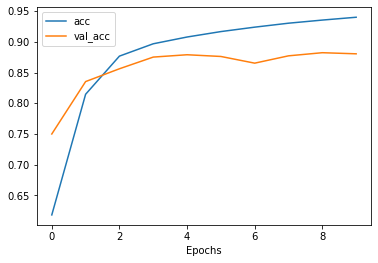

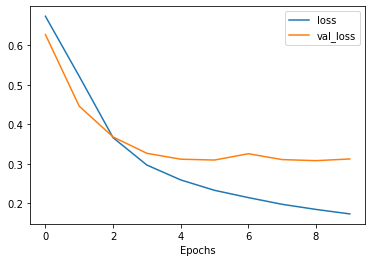

In [59]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["acc", "val_acc"])
plt.xlabel("Epochs")
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.xlabel("Epochs")

You can see that the loss is going down very slowly and that is because we are using subwords and not full words and they dont mean anything unless they come in a sequence. This is where the model is failing. The order of the subwords is not retained in the model. 

In [61]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

out_v = io.open('data/tokenizer_&_basicDense/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('data/tokenizer_&_basicDense/meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


(8185, 64)
